In [4]:
%clear
import tensorflow as tf
import numpy as np
import argparse
import socket
import importlib
import time
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

import scipy.misc
import sys
BASE_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(BASE_DIR) +'/pointnet2-master'
sys.path.append(BASE_DIR)
sys.path.append(ROOT_DIR)
print('BASE_DIR =' ,BASE_DIR)
print('ROOT_DIR =' ,ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
import provider
import modelnet_dataset
import modelnet_h5_dataset
import otherClassDataImport as chao_data_import
import EvaluationFunction as Evaluate

BASE_DIR = /home/chaotang/文档/Try
ROOT_DIR = /home/chaotang/文档/pointnet2-master


MODEL_PATH /home/chaotang/文档/pointnet2-master/log/model.ckpt
cur_batch_data (16, 2048, 3)
cur_batch_label (16,)
Original_pl (16, 2048, 3)


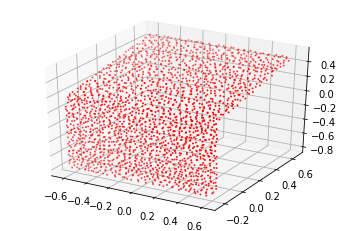

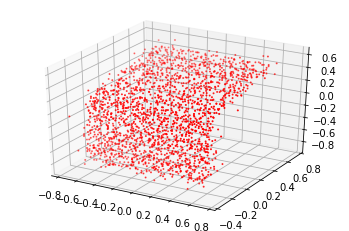

In [55]:
BATCH_SIZE = 16
NUM_POINT = 2048
MODEL_PATH = ROOT_DIR + '/log/model.ckpt'
print('MODEL_PATH',MODEL_PATH)
GPU_INDEX =0
MODEL = importlib.import_module('pointnet2_cls_ssg') # import network module

test_index = 0
# Make sure batch data is of same size
cur_batch_data = np.zeros((BATCH_SIZE,NUM_POINT,3))
cur_batch_label = np.zeros((BATCH_SIZE), dtype=np.int32)

Original_pl = np.zeros((BATCH_SIZE,NUM_POINT,3))
Noisy_pl = np.zeros((BATCH_SIZE,NUM_POINT,3))

cur_batch_data,cur_batch_label = chao_data_import.get_data()
print('cur_batch_data',cur_batch_data.shape)# The shape of the data set is (16, 2048, 3)
print('cur_batch_label',cur_batch_label.shape)

Original_pl[:] = cur_batch_data[:]# 干净的点云
Noisy_pl[:] = cur_batch_data[:]# 有噪音的点云
Original_label = np.zeros(cur_batch_label.shape)
Original_label[:] = cur_batch_label[:]
print('Original_pl',Original_pl.shape)
chao_data_import.draw_pointcloud(Original_pl[test_index])
########################只有前k个点加上了噪音##############################################
k = 1000
Noisy_pl[test_index,0:k,:] = Original_pl[test_index,0:k,:] + 0.05 * np.random.normal(size = (k,3))# Noisy的点云

chao_data_import.draw_pointcloud(Noisy_pl[test_index])

In [13]:
# Use 16 plane to compute feature map first
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
is_training = False
is_training_pl = tf.placeholder(tf.bool, shape=())
# def placeholder_inputs(batch_size, num_point):
pointclouds_pl = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_POINT, 3)) # shape = (16,1024,3)

pred,end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
saver = tf.train.Saver()
with tf.device('/gpu:0'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
with tf.Session() as sess:
    saver.restore(sess,MODEL_PATH)
    print('Model restored!!!!!')
    print('Calculating....')
    feed = {pointclouds_pl:Original_pl,is_training_pl:is_training}   
    _,endpoint_clean = sess.run([pred,end_points],feed_dict = feed)# Try to check the feature vector for clean point
    feature_vector = endpoint_clean['l3_points'] # shape = (16,1,1024)
    print('The feature for one batch has been generated')

INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/log/model.ckpt
Model restored!!!!!
Calculating....
The feature for one batch has been generated


In [14]:
feature_vector = np.reshape(feature_vector,(16,1024))
feature_mean = np.mean(feature_vector,axis = 0)
feature_cov = np.cov(np.transpose(feature_vector))

sample_feature = np.random.multivariate_normal(mean=feature_mean, cov=feature_cov, size=1)
# sample_feature shape = (1,1024)
# feature_vector shape = (1024,)

(16, 2048, 3)
(16, 1000, 3)
(16, 1048, 3)
clean_feature (1, 1024)
current (1, 1024)
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/log/model.ckpt
Model restored!!!!!
Calculating....
E2_val 140.90804
E1_val 193.27309
Original_score  -0.0
predval [-16.206469 -26.219477  -7.910724 -19.218445 -25.055449 -32.45299
 -16.868538 -36.341763 -10.376788 -16.485165 -19.886557 -12.280809
 -34.85182  -14.808078 -23.177046 -28.470917 -18.790802 -27.714123
 -10.457559 -44.303394  12.594796 -26.851057 -12.69431  -18.846634
 -47.549366 -39.222294 -27.986664 -19.232899 -14.748199 -18.154066
 -18.051641 -22.754349 -28.702257 -23.069996 -19.058306 -34.15283
 -11.78567  -24.664164 -32.524715 -27.955582]
displacement 1.9328222


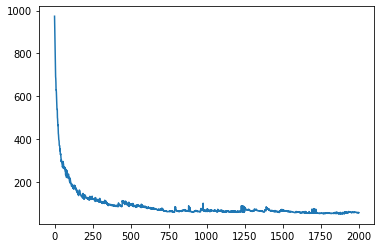

In [56]:
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
num_votes = 1
is_training = False

is_training_pl = tf.placeholder(tf.bool, shape=())
# def placeholder_inputs(batch_size, num_point):
pointclouds_pl = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_POINT, 3)) # shape = (16,1024,3)
labels_pl = tf.placeholder(tf.int32, shape=(BATCH_SIZE))

# define delta P which can be optimized by tensorflow

# deltaP = tf.get_variable('deltaP',dtype=tf.float32,shape = pointclouds_pl.shape,initializer=tf.zeros_initializer)
deltaP = tf.get_variable('deltaP',dtype=tf.float32,shape = (BATCH_SIZE,k,3),initializer=tf.zeros_initializer)
#FixedP = tf.get_variable('deltaP',dtype=tf.float32,shape = (BATCH_SIZE,NUM_POINT-100,3),initializer=tf.zeros_initializer)
Part1 = pointclouds_pl[:,0:k,:] + deltaP
Part2 = pointclouds_pl[:,k:,:]
New_pcloud_pl = tf.concat([Part1,Part2],axis = 1)

print(New_pcloud_pl.shape)
print(Part1.shape)
print(Part2.shape)
#New_pcloud_pl =  deltaP

pred,end_points = MODEL.get_model(New_pcloud_pl, is_training_pl)

##########################################################
# define enegy function
# Use the feature vector to denoise
clean_feature = sample_feature
current_feature = end_points['l3_points'][test_index]
print('clean_feature',clean_feature.shape)
print('current',current_feature.shape)

E1 = 100 * tf.reduce_sum(tf.square(deltaP[test_index]))
E2 = tf.reduce_sum(tf.square(clean_feature - current_feature))
E3 = - 0 * pred[test_index,int(Original_label[test_index])]
#E_total =  E2 + E1 + E3 # scalar tensor
E_total =  E2  + E3 # scalar tensor
    
# optimizer define
optimizer = tf.train.GradientDescentOptimizer(0.00001)
#optimizer = tf.contrib.opt.GGTOptimizer()
train_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope = 'deltaP:0')
train_op = optimizer.minimize(E_total,var_list = train_var)
# feed director
######################################################################
pre_trained_list = []
var_list = []
for var in tf.global_variables():# 并不是model用的都是trainable的
    #print(var.name)
    var_list.append(var)
pre_trained_list = var_list[1:]
#for var in pre_trained_list:
    #print(var.name)
##################################
####### Graph has been redefine###
#################################
# 训练条件配置
saver = tf.train.Saver(var_list=pre_trained_list)

init = tf.global_variables_initializer()
# Create a session(如果没有下面这一串的sess指令，回复会出错)
with tf.device('/gpu:0'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
with tf.Session() as sess:
    sess.run(tf.variables_initializer([deltaP])) # BN层没有运用，但也需要初始化
    sess.run(init)

    saver.restore(sess,MODEL_PATH)
    print('Model restored!!!!!')
    '''
    strangeTensor = var_list[5].name
    graph = tf.get_default_graph()
    Tensor = graph.get_tensor_by_name(strangeTensor)
    print(strangeTensor)
    print(Tensor.eval())
    '''
    print('Calculating....')
    clean_feed = {pointclouds_pl:Original_pl,is_training_pl:is_training}
    _,original_Score,E2_val = sess.run([train_op,E3,E2],feed_dict = clean_feed)
    
    feed = {pointclouds_pl:Noisy_pl,is_training_pl:is_training}
    loss_mat = np.zeros((2000,))
    
    for i in range(2000):
        #_,loss_in_loop,E3_val,predval = sess.run([train_op,E_total,E3,pred],feed_dict = feed)
        _,loss_in_loop,predval,E1_val = sess.run([train_op,E_total,pred,E1],feed_dict = feed)
        loss_mat[i] = loss_in_loop
    print('E2_val',E2_val)
    print('E1_val',E1_val)
    displacement = deltaP[test_index].eval()
    print('Original_score ',-original_Score)

    print('predval',predval[test_index])
    print('displacement',np.sum(np.square(displacement)))
plt.plot(loss_mat)

1.9328221875979736
chamfer_noisy 0.16470417524456024
chamfer_new 0.10029972576726472
RMSD_noisy 3.1617334433032127
RMSD_new 2.101243749714766


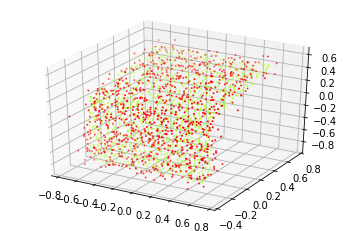

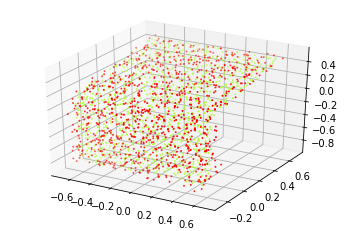

In [58]:
processed_displace = np.zeros((2048,3))
processed_displace[0:k] = displacement
New_pl = np.clip((processed_displace + Noisy_pl[test_index]),-1,1)

#chao_data_import.draw_pointcloud(Noisy_pl[test_index])
#chao_data_import.draw_pointcloud(New_pl)

plt.figure()
x,y,z = Noisy_pl[test_index][0:k,0],Noisy_pl[test_index][0:k,1],Noisy_pl[test_index][0:k,2]
x2,y2,z2 = Noisy_pl[test_index][k:,0],Noisy_pl[test_index][k:,1],Noisy_pl[test_index][k:,2]
ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
ax.scatter(x,y,z,c = 'r',s = 1)
# ax.scatter(x2,y2,z2,c = 'r',s = 1)
ax.scatter(x2,y2,z2,c = 'greenyellow',s = 1)

plt.figure()
x,y,z = New_pl[0:k,0],New_pl[0:k,1],New_pl[0:k,2]
x2,y2,z2 = New_pl[k:,0],New_pl[k:,1],New_pl[k:,2]
ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
ax.scatter(x,y,z,c = 'r',s = 1)
ax.scatter(x2,y2,z2,c = 'greenyellow',s = 1)

difference = np.sum(np.square(New_pl - Noisy_pl[test_index]))
print(difference)
###################################################
################### Evaluation ####################
###################################################
chamfer_noisy  = 100 * Evaluate.chamfer_dist(Original_pl[test_index],Noisy_pl[test_index])
chamfer_new  = 100 * Evaluate.chamfer_dist(Original_pl[test_index],New_pl)
print('chamfer_noisy',chamfer_noisy)
print('chamfer_new',chamfer_new)

RMSD_noisy  = 100 * Evaluate.RMSD(Original_pl[test_index],Noisy_pl[test_index])
RMSD_new  = 100 * Evaluate.RMSD(Original_pl[test_index],New_pl)
print('RMSD_noisy',RMSD_noisy)
print('RMSD_new',RMSD_new)

In [19]:
import show3d_balls as show3dball

In [61]:
show3dball.showpoints(Noisy_pl[test_index])

113

In [62]:
show3dball.showpoints(New_pl)

113